# 2D DC Resistivity Inversion with SimPEGTorch

This notebook demonstrates a 2D DC resistivity inversion using simpegtorch with a TensorMesh. The example is based on the simpeg user-tutorials but implemented using simpegtorch's PyTorch-based framework.

## Overview
- Create a 2D TensorMesh
- Design a dipole-dipole survey
- Generate synthetic data with a conductive block anomaly
- Run weighted least-squares inversion
- Visualize results

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from simpegtorch.discretize import TensorMesh
from simpegtorch.simulation.resistivity import (
    DC2DCellCentered,
    SrcDipole,
    RxDipole,
    Survey,
)
from simpegtorch.simulation.base import DirectSolver, mappings
from simpegtorch.discretize.utils import ndgrid
from simpegtorch.inversion import (
    BaseInversion,
    BaseInvProblem,
    BetaSchedule,
    TargetMisfit,
    BetaEstimate_ByEig,
)
from simpegtorch.data_misfit import L2DataMisfit
from simpegtorch.regularization import WeightedLeastSquares

torch.set_default_dtype(torch.float64)
np.random.seed(42)
torch.manual_seed(42)

## Step 1: Create 2D TensorMesh

We create a 2D tensor mesh with fine discretization near the surface and coarser cells at depth. The mesh extends beyond the survey area to minimize boundary effects.

In [53]:
# Horizontal discretization
dx = 5.0  # 5m cell width in survey region
hx = [(dx, 10, -1.3), (dx, 60), (dx, 10, 1.3)]

# Vertical discretization  
dz = 5.0  # 5m cell width near surface
hz = [(dz, 10, 1.3), (dz, 15)]

# Create mesh with origin at top center
mesh = TensorMesh([hx, hz], origin="CN")
mesh.origin[1] = -mesh.h[1].sum()  # Set y-origin at surface (y=0)

print(mesh)



  TensorMesh: 1,975 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     79       -392.56        392.56      5.00     68.93   10.60
   y     25       -352.03          0.00      5.00     68.93   13.79




## Step 2: Create True Conductivity Model

We define a halfspace background with a conductive rectangular block anomaly.

/tmp/ipykernel_143897/3989275235.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  dist = np.linalg.norm(mesh.gridCC[i, :] - center)


Text(0.5, 1.0, 'True Resistivity Model')

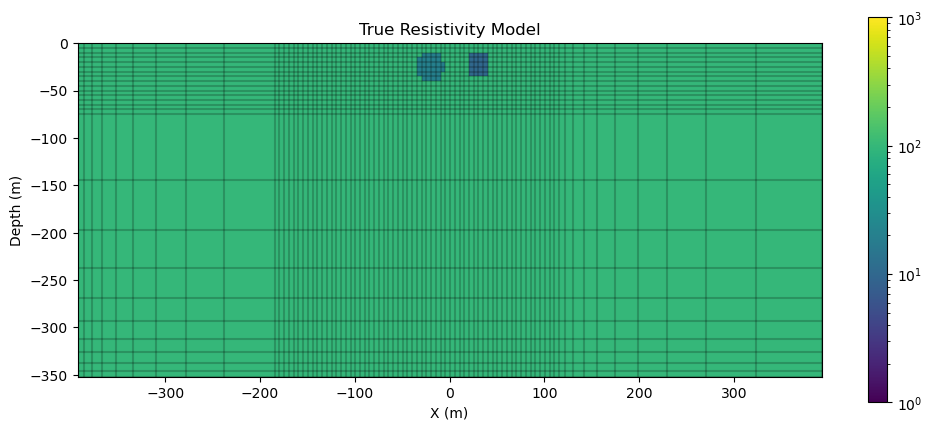

In [ ]:
# Background conductivity (100 Ohm-m resistivity)
sigma_background = 1.0 / 100.0
sigma_true = torch.ones(mesh.nC) * sigma_background

# Add conductive block (10 Ohm-m resistivity)
sigma_block = 1.0 / 10.0
ind_block = (
    (mesh.gridCC[:, 0] > 20.0) &
    (mesh.gridCC[:, 0] < 40.0) &
    (mesh.gridCC[:, 1] > -35.0) &
    (mesh.gridCC[:, 1] < -10.0)
)
sigma_true[ind_block] = sigma_block

## Create a conductive sphere
center = np.array([-20.0, -25.0])
radius = 15.0

for i in range(mesh.nC):
    dist = np.linalg.norm(mesh.gridCC[i, :] - center)
    if dist < radius:
        sigma_true[i] = sigma_block  # 20 Ohm-m resistivity
# True resistivity model

# Plot true model
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
mesh.plot_image(
    1.0 / sigma_true,  # Plot resistivity
    ax=ax,
    pcolor_opts={"cmap": "viridis", "norm": LogNorm(vmin=1, vmax=1000)},
)
# add grid lines
mesh.plot_grid(ax=ax, alpha=0.2)
ax.set_xlabel("X (m)")
ax.set_ylabel("Depth (m)")
ax.set_title("True Resistivity Model")

## Step 3: Design Dipole-Dipole Survey

We create a dipole-dipole array with multiple dipole spacings (a) and separations (n). This is a common configuration for 2D DC resistivity surveys.

In [ ]:
from simpegtorch.simulation.resistivity import sources, receivers


end_locations = torch.tensor([-400.0, 400.0])
station_spacing = 40.0
num_rx_per_src = 10

electrode_locations_x = torch.arange(-400.0, 400.0 + station_spacing, station_spacing)
electrode_locations_y = torch.zeros_like(electrode_locations_x)
electrode_locations = torch.stack([electrode_locations_x, electrode_locations_y], dim=1)
n_electrodes = electrode_locations.shape[0]

source_list = []
ii = 0
while ii < n_electrodes - 3:
    # A and B electrode locations
    location_a = electrode_locations[ii, :]
    location_b = electrode_locations[ii + 1, :]

    # M and N electrode locations
    ii_max = np.min([ii + 3 + num_rx_per_src, n_electrodes])
    locations_m = electrode_locations[ii + 2 : ii_max - 1]
    locations_n = electrode_locations[ii + 3 : ii_max]

    # Define receivers for source ii
    receivers_list = [
        receivers.Dipole(
            locations_m=locations_m, locations_n=locations_n
        )
    ]

    # Append source ii to list
    source_list.append(
        sources.Dipole(receivers_list, location_a=location_a, location_b=location_b)
    )

    ii += 1

# Define survey
survey = Survey(source_list)

Survey created with 18 source dipoles
Total number of data: 123


## Step 4: Generate Synthetic Data

We simulate the DC resistivity response using the true model and add Gaussian noise.

In [129]:
# Create forward simulation with true model
sigma_map_true = mappings.BaseMapping(sigma_true)

pde_true = DC2DCellCentered(
    mesh,
    survey,
    sigma_map_true,
    nky=21,  # Number of Fourier modes
    do_trap=True,
)

solver_true = DirectSolver(pde_true)
data_clean = solver_true.forward()

# Add noise: 5% relative + 1e-6 floor
noise_percent = 0.02
noise_floor = 1e-9
std = noise_percent * torch.abs(data_clean) + noise_floor
noise = torch.randn_like(data_clean) * std
data_obs = data_clean + noise

print(f"Data shape: {data_obs.shape}")
print(f"Data range: [{data_obs.min():.2e}, {data_obs.max():.2e}]")

Data shape: torch.Size([123])
Data range: [-5.16e-05, 2.02e-09]


## Step 5: Visualize Observed Data

We can plot the data as a function of receiver location or create a pseudosection.

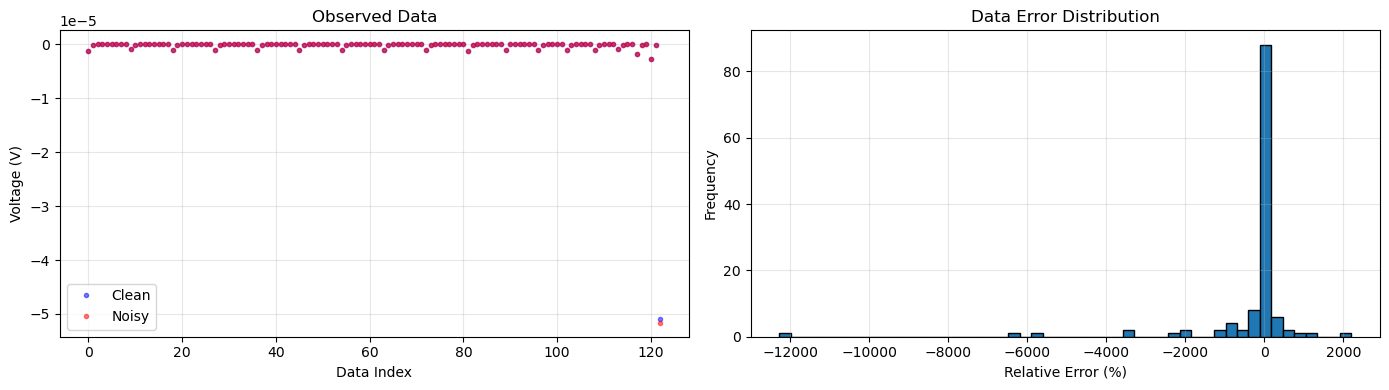

In [130]:
# Plot data comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Plot clean vs noisy data
ax = axes[0]
ax.plot(data_clean.detach().numpy(), 'b.', label='Clean', alpha=0.5)
ax.plot(data_obs.detach().numpy(), 'r.', label='Noisy', alpha=0.5)
ax.set_xlabel('Data Index')
ax.set_ylabel('Voltage (V)')
ax.set_title('Observed Data')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot histogram of relative errors
ax = axes[1]
relative_error = ((data_obs - data_clean) / data_clean * 100).detach().numpy()
ax.hist(relative_error, bins=50, edgecolor='black')
ax.set_xlabel('Relative Error (%)')
ax.set_ylabel('Frequency')
ax.set_title('Data Error Distribution')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Observed Data Pseudosection')

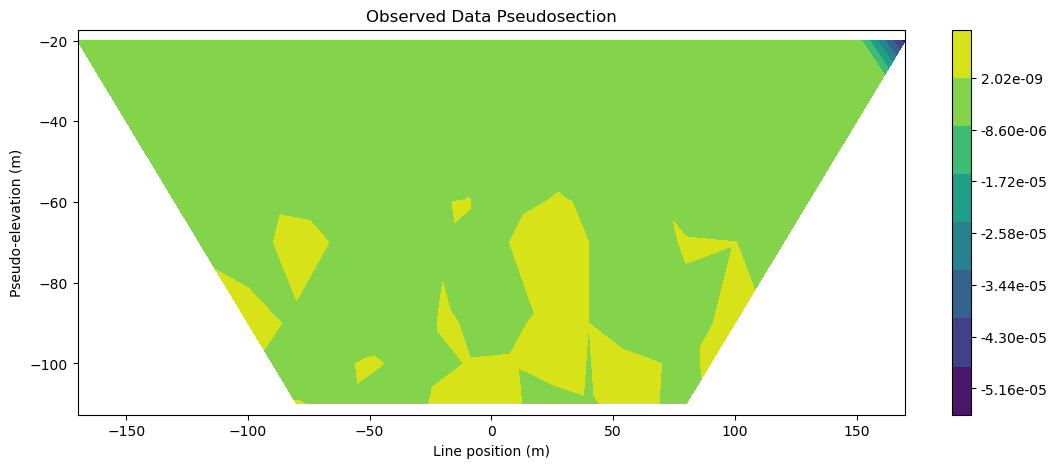

In [131]:
## Visualize the data in a pseudosection
from simpegtorch.simulation.utils import plot_pseudosection
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
plot_pseudosection(
    dobs=data_obs,
    survey=survey,
    ax=ax,
    cbar_opts={"label": "Voltage (V)"},
    pcolor_opts={"cmap": "viridis"},
)
ax.set_title("Observed Data Pseudosection")

## Step 6: Set Up Inversion

We set up the inversion to recover log-conductivity using:
- L2 data misfit
- Weighted least-squares regularization (smoothness)
- LBFGS optimizer
- Beta cooling schedule

In [ ]:
# Starting model: uniform halfspace
sigma_start = sigma_background
m0 = torch.log(torch.ones(mesh.nC) * sigma_start)

# Create mapping for inversion (log conductivity)
sigma_map = mappings.LogMapping(m0.clone())

# Create forward simulation for inversion
pde_inv = DC2DCellCentered(
    mesh,
    survey,
    sigma_map,
    nky=21,
    do_trap=True,
)

solver_inv = DirectSolver(pde_inv)

# Data misfit
data_misfit = L2DataMisfit(solver_inv, data_obs, 1.0 / std)

# Regularization: smooth model with stronger smoothness in x than y
regularization = WeightedLeastSquares(
    mesh,
    mapping=sigma_map,
    alpha_s=1e-3,  # Smallness weight
    alpha_x=1.0,   # Smoothness in x
    alpha_y=1.0,   # Smoothness in y (depth)
)

# Optimizer
optimizer = torch.optim.LBFGS(
    params=[{"params": sigma_map.parameters()}],
    lr=1.0,
    max_iter=10,
    line_search_fn="strong_wolfe",
)

# optimizer = torch.optim.Adam(
#     params=[{"params": sigma_map.parameters()}],
#     lr=1e-2,
# )

# Inversion problem
inv_prob = BaseInvProblem(
    data_misfit,
    regularization,
    optimizer,
    beta=1.0,
    max_iter=100,
)

# Directives
directives = [
    BetaEstimate_ByEig(),  # Estimate initial beta
    BetaSchedule(cooling_factor=2.0, cooling_rate=2),  # Cool beta every 2 iterations
    TargetMisfit(chi_factor=0.5),  # Target chi-squared = 1
]

# Create inversion
inversion = BaseInversion(inv_prob, directives)

print("Inversion setup complete")

Inversion setup complete


## Step 7: Run Inversion

In [ ]:
# Run inversion
inversion.run()

BetaEstimate: β set to 5.85e+04 (ratio = 1.0)
TargetMisfit: target = 6.15e+01
Running inversion with 3 directives
Device: cpu, dtype: torch.float64
Iter   0: φ = 3.24e+03 (φ_d = 1.62e+03, β×φ_m = 1.62e+03) 
Iter   1: φ = 2.79e+03 (φ_d = 1.18e+03, β×φ_m = 1.61e+03) 
BetaSchedule: β reduced from 5.85e+04 to 2.93e+04
Iter   2: φ = 1.71e+03 (φ_d = 9.30e+02, β×φ_m = 7.80e+02) 
Iter   3: φ = 1.32e+03 (φ_d = 5.68e+02, β×φ_m = 7.53e+02) 
BetaSchedule: β reduced from 2.93e+04 to 1.46e+04
Iter   4: φ = 7.70e+02 (φ_d = 4.03e+02, β×φ_m = 3.67e+02) 
Iter   5: φ = 6.69e+02 (φ_d = 3.09e+02, β×φ_m = 3.60e+02) 
BetaSchedule: β reduced from 1.46e+04 to 7.32e+03
Iter   6: φ = 4.01e+02 (φ_d = 2.25e+02, β×φ_m = 1.77e+02) 
Iter   7: φ = 3.67e+02 (φ_d = 1.93e+02, β×φ_m = 1.74e+02) 
BetaSchedule: β reduced from 7.32e+03 to 3.66e+03
Iter   8: φ = 2.56e+02 (φ_d = 1.70e+02, β×φ_m = 8.61e+01) 
Iter   9: φ = 2.38e+02 (φ_d = 1.52e+02, β×φ_m = 8.59e+01) 
BetaSchedule: β reduced from 3.66e+03 to 1.83e+03
Iter  10: φ 

## Step 8: Visualize Results

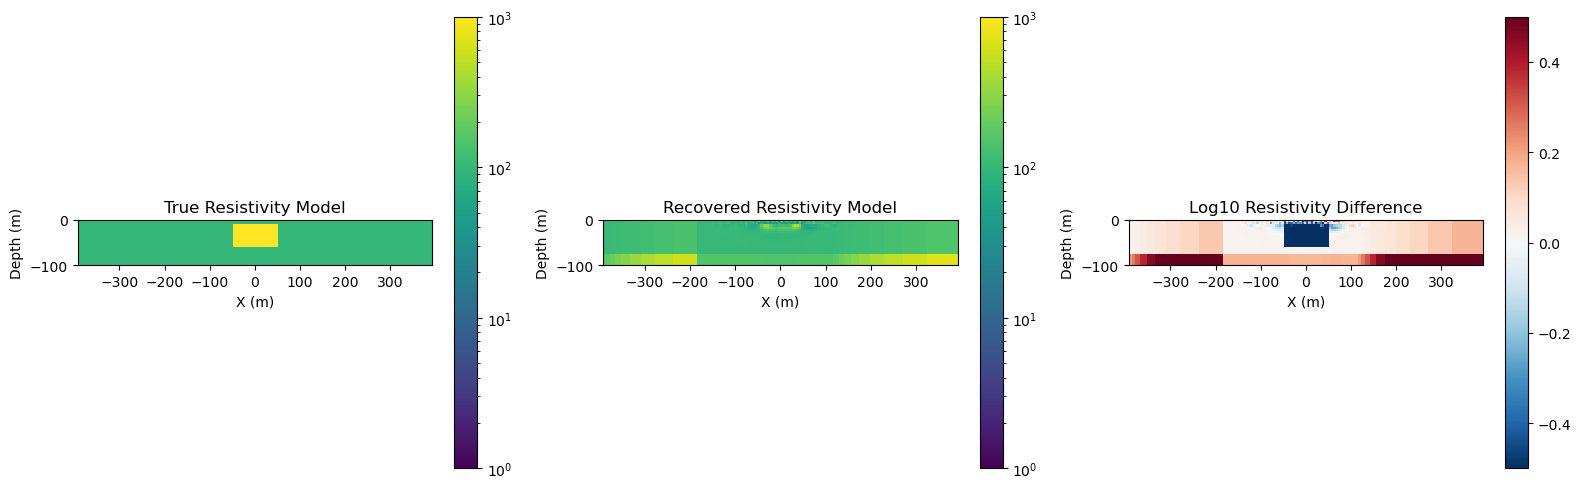

In [ ]:
# Get recovered model
sigma_recovered = sigma_map.forward().detach()
rho_recovered = 1.0 / sigma_recovered
rho_true = 1.0 / sigma_true

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# True model
ax = axes[0]
im = mesh.plot_image(
    rho_true,
    ax=ax,
    pcolor_opts={"cmap": "viridis", "norm": LogNorm(vmin=1, vmax=1000)},
)
ax.set_xlabel("X (m)")
ax.set_ylabel("Depth (m)")
ax.set_title("True Resistivity Model")
ax.set_ylim([-100, 0])

# Recovered model
ax = axes[1]
im = mesh.plot_image(
    rho_recovered,
    ax=ax,
    pcolor_opts={"cmap": "viridis", "norm": LogNorm(vmin=1, vmax=1000)},
)
ax.set_xlabel("X (m)")
ax.set_ylabel("Depth (m)")
ax.set_title("Recovered Resistivity Model")
ax.set_ylim([-100, 0])

# Difference
ax = axes[2]
diff = torch.log10(rho_recovered) - torch.log10(rho_true)
im = mesh.plot_image(
    diff,
    ax=ax,
    pcolor_opts={"cmap": "RdBu_r", "vmin": -0.5, "vmax": 0.5},
)
ax.set_xlabel("X (m)")
ax.set_ylabel("Depth (m)")
ax.set_title("Log10 Resistivity Difference")
ax.set_ylim([-100, 0])

plt.tight_layout()
plt.show()